In [1]:
import json
import numpy as np
import cv2
import os
from glob import glob
# from utils import *
import tensorflow as tf
from tensorflow import keras 
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow.keras import applications
from tensorflow.keras.optimizers import Adam


# augmented data

In [2]:
x  = np.load("aug_images_train.npy")
Labels = np.load("aug_label_train.npy")

In [3]:
X_train , X_test, y_train , y_test = x ,np.load("./data/test_image.npy") , Labels , np.load("./data/test_label.npy")

In [4]:
normal_imgss = [np.dstack((X_test[i], X_test[i], X_test[i])) for i in range(0,len(X_test))]
# imgss = [np.stack((imgs[i], imgs[i], imgs[i]), axis=2) for i in range(0,len(imgs_test))]
X_test = np.array(normal_imgss)

In [5]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)

# ResNet50V2

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from livelossplot import PlotLossesKerasTF

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.0002, mode='min')
# checkpoint = ModelCheckpoint("resnet_v250", monitor='val_accuracy',
#                              save_weights_only=True, mode='max', verbose=1)
earlyStop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    verbose=1,
    mode='auto',
    restore_best_weights=True,
)
callbacks = [PlotLossesKerasTF(), reduce_lr, earlyStop]

In [9]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from keras.models import Model
import keras
dim = 128
restnet50v2 = ResNet50V2(include_top=False, weights='imagenet', input_shape=(dim,dim,3))

for layer in restnet50v2.layers[:143]:
    layer.trainable = False
restnet50v2.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 66, 66, 64)   0           ['conv1_conv[0][0]']    

In [10]:
model = keras.models.Sequential()
model.add(keras.layers.Lambda(lambda im: tf.image.resize(im, (128, 128))))
model.add(restnet50v2)
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(4, activation='softmax'))

model.compile(optimizer = Adam(learning_rate=0.0002,beta_1=0.95,beta_2=0.9995,epsilon=1e-08) ,loss='categorical_crossentropy', metrics=['accuracy'])

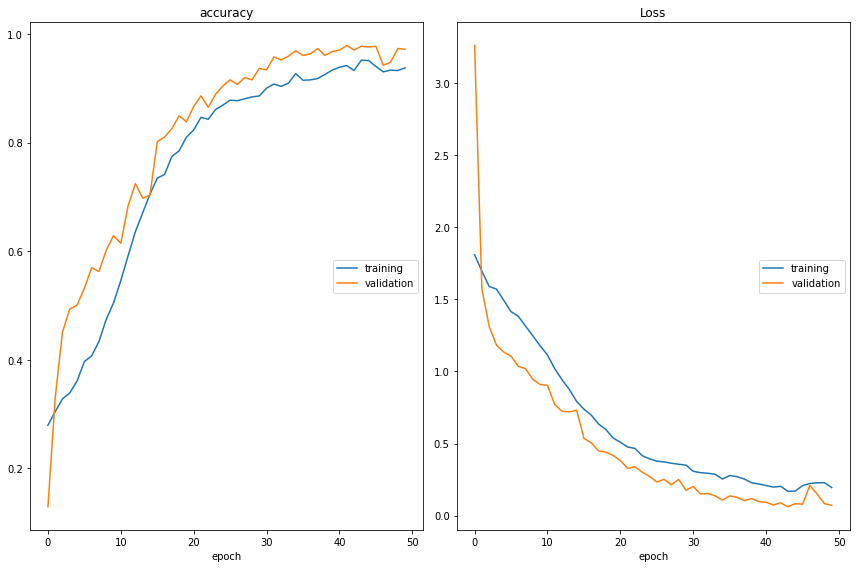

accuracy
	training         	 (min:    0.279, max:    0.952, cur:    0.938)
	validation       	 (min:    0.129, max:    0.979, cur:    0.972)
Loss
	training         	 (min:    0.168, max:    1.810, cur:    0.194)
	validation       	 (min:    0.061, max:    3.263, cur:    0.071)
89/89 [==============================] - 5s 51ms/step - loss: 0.1942 - accuracy: 0.9377 - val_loss: 0.0709 - val_accuracy: 0.9719 - lr: 2.0000e-04


In [11]:
history = model.fit(X_train,y_train,batch_size = 32,
                              epochs=50, 
                              shuffle=True, 
                              verbose=True,
                              validation_split=0.2,
                              callbacks=callbacks
                              )

In [12]:
model.save("./saved_model/resnet")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on

/home/computer/anaconda3/envs/mcgan/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/computer/anaconda3/envs/mcgan/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [6]:
from tensorflow import keras
model = keras.models.load_model('saved_model/densenet201')

In [7]:
y_pred = model.predict(X_test)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
np.array([2.16341183e-01, 3.51547211e-01, 3.25863242e-01, 1.06248379e-01]).argmax(axis=0)

1

In [8]:
y_pred

array([[7.07074360e-05, 5.74468913e-06, 9.99846697e-01, 7.69062826e-05],
       [6.63154542e-01, 4.40702699e-02, 2.85653293e-01, 7.12193409e-03],
       [5.65150604e-02, 8.48912358e-01, 7.99251422e-02, 1.46474736e-02],
       [2.45550815e-02, 3.40111069e-02, 9.37776625e-01, 3.65714775e-03],
       [3.20751190e-01, 5.71526229e-01, 5.00885174e-02, 5.76340891e-02],
       [9.01716109e-03, 1.46276946e-03, 9.88088667e-01, 1.43131765e-03],
       [9.00466681e-01, 2.16466896e-02, 7.07685128e-02, 7.11817713e-03],
       [1.38047524e-02, 6.03064716e-01, 3.77206832e-01, 5.92366140e-03],
       [7.62561187e-02, 7.46318638e-01, 1.65370196e-01, 1.20551297e-02],
       [2.74538267e-02, 8.19278955e-01, 1.32673964e-01, 2.05932837e-02],
       [9.99889851e-01, 1.35048788e-06, 6.04708694e-05, 4.83943222e-05],
       [3.74187738e-01, 3.26583683e-01, 2.76660830e-01, 2.25677751e-02],
       [9.77593241e-04, 9.96132374e-01, 6.41404418e-04, 2.24869698e-03],
       [9.09254327e-03, 4.10735533e-02, 9.44931030e

In [9]:
y_pred_new = []
for i  in y_pred : 
    y_pred_new.append(i.argmax(axis=0))

In [10]:
y_pred_new

[2,
 0,
 1,
 2,
 1,
 2,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 0,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 0,
 2,
 0,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 1,
 1,
 0,
 2,
 0,
 2,
 1,
 2,
 1,
 0,
 2,
 1,
 0,
 2,
 2,
 1,
 0,
 1,
 2,
 2,
 2,
 2,
 0,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 0,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 3,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 0,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 3,
 2,
 1,
 0,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 0,
 3,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 0,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 0,
 2,
 2,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 2,
 0,
 2,
 2,
 2,
 1,
 2]

In [11]:
from sklearn.metrics import multilabel_confusion_matrix

print(multilabel_confusion_matrix(y_test,y_pred_new))

[[[162  20]
  [ 32   8]]

 [[ 80  52]
  [ 50  40]]

 [[ 80  58]
  [ 43  41]]

 [[212   2]
  [  7   1]]]


In [12]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(y_pred_new,y_test)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.2        0.44444444 0.48809524 0.125     ]
recall: [0.28571429 0.43478261 0.41414141 0.33333333]
fscore: [0.23529412 0.43956044 0.44808743 0.18181818]
support: [28 92 99  3]


# VGG

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from livelossplot import PlotLossesKerasTF

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.0002, mode='min')
# checkpoint = ModelCheckpoint("resnet_v250", monitor='val_accuracy',
#                              save_weights_only=True, mode='max', verbose=1)
earlyStop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='auto',
    restore_best_weights=True,
)
callbacks = [PlotLossesKerasTF(), reduce_lr, earlyStop]

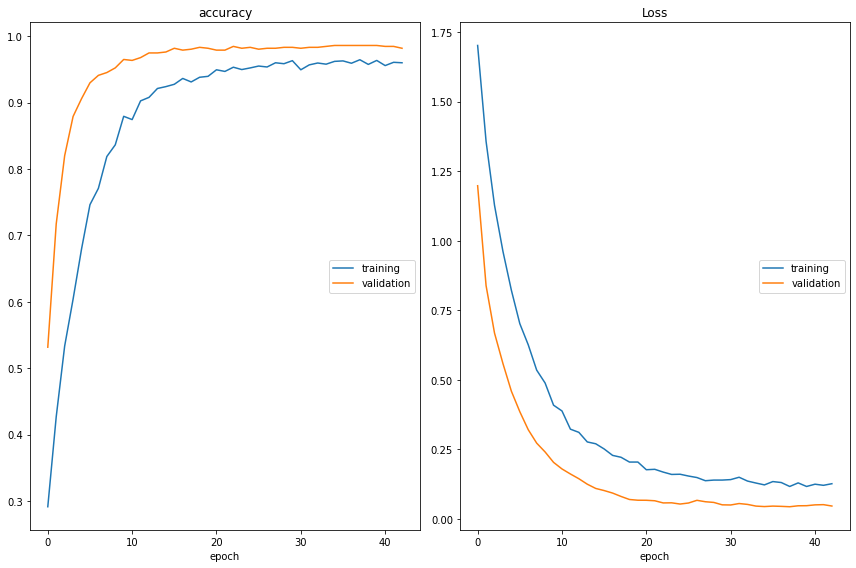

accuracy
	training         	 (min:    0.291, max:    0.964, cur:    0.960)
	validation       	 (min:    0.532, max:    0.986, cur:    0.982)
Loss
	training         	 (min:    0.116, max:    1.702, cur:    0.126)
	validation       	 (min:    0.044, max:    1.198, cur:    0.046)
Restoring model weights from the end of the best epoch: 38.
89/89 [==============================] - 3s 28ms/step - loss: 0.1263 - accuracy: 0.9599 - val_loss: 0.0461 - val_accuracy: 0.9817 - lr: 2.0000e-04
Epoch 00043: early stopping
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has

In [21]:
print(X_train.shape)
input_tensor = keras.Input(shape=X_train.shape[1:])
vgg = keras.applications.vgg19.VGG19(include_top=False, weights="imagenet", input_tensor=input_tensor)

# Freeze all blocks except last
#for l in resnet[:143]:
vgg.trainable = False

model = keras.models.Sequential()
#model.add(keras.layers.Lambda(lambda im: tf.image.resize(im, (256, 256))))
model.add(vgg)
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5))
# model.add(keras.layers.BatchNormalization())
# model.add(keras.layers.Dense(128, activation='relu'))
# model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(4, activation='softmax'))

model.compile(optimizer = Adam(learning_rate=0.0002,beta_1=0.95,beta_2=0.9995,epsilon=1e-08) ,loss='categorical_crossentropy', 
            #   optimizer=optimizers.SGD(lr=1e-4, 
            #                            momentum=0.9),
              metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1 ,  validation_split=0.2, callbacks=callbacks)

model.save("saved_model/vgg16")
print("done")

In [22]:
import matplotlib.pyplot as plt 

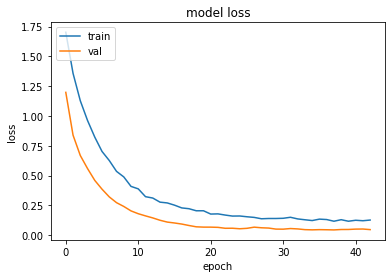

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [13]:
from tensorflow import keras
model = keras.models.load_model('saved_model/vgg16')

In [14]:
y_pred = model.predict(X_test)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [15]:
y_pred_new = []
for i  in y_pred : 
    y_pred_new.append(i.argmax(axis=0))

In [16]:
from sklearn.metrics import multilabel_confusion_matrix

mx = multilabel_confusion_matrix(y_test,y_pred_new)

In [17]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(y_pred_new, y_test)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.25       0.4        0.60714286 0.        ]
recall: [0.33333333 0.46153846 0.45535714 0.        ]
fscore: [0.28571429 0.42857143 0.52040816 0.        ]
support: [ 30  78 112   2]


In [18]:
mx

array([[[162,  20],
        [ 30,  10]],

       [[ 90,  42],
        [ 54,  36]],

       [[ 77,  61],
        [ 33,  51]],

       [[212,   2],
        [  8,   0]]])

In [20]:
from sklearn.metrics import multilabel_confusion_matrix , accuracy_score
import matplotlib.pyplot as plt 

mx = multilabel_confusion_matrix(y_test,y_pred_new)
acc = accuracy_score(y_test,y_pred_new)

In [21]:
acc

0.4369369369369369

: 